In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import sqlite3 as sql
import os
import pandas as pd
from datetime import datetime
from glob import glob
import sklearn as sk
from sklearn import linear_model, cluster

os.sys.path.append('../')
import PlaceCellAnalysis as pc
import utilities as u
import preprocessing as pp
import behavior as b
import BayesianDecoding as bd


%load_ext autoreload
%autoreload 2

%matplotlib inline

In [57]:
mice = ['4139190.1','4139190.3','4139212.2','4139219.2','4139219.3','4139224.2','4139224.3','4139224.5']

In [58]:
df = pp.load_session_db()
df = df[df['Imaging']==1]
df = df.sort_values(['MouseName','DateTime','SessionNumber'])


In [59]:
# FDR 
def FDR(P,q=.001):
    sort = np.argsort(P)
    P = P[sort]
    thr = 0
    while P[thr]<=(thr+1)/P.shape[0]*q:
        thr+=1
    sigInds = sort[:thr]
    return sigInds


    

SyntaxError: invalid syntax (<ipython-input-59-9d0e36e37008>, line 11)

G:\My Drive\\VR_Data\TwoTower\4139190.1\16_06_2018\TwoTower_Timeout_2.sqlite


C:\Users\mplitt\Anaconda3\lib\site-packages\pandas\core\frame.py:3790: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
C:\Users\mplitt\MightyMorphingPhotonRangers\utilities.py:251: RuntimeWarning: Mean of empty slice
  if rewards[i]>0 and max_pos[i]>rzone1[1]:


G:\My Drive\\VR_Data\TwoTower\4139190.1\19_06_2018\TwoTower_Timeout_2.sqlite


C:\Users\mplitt\MightyMorphingPhotonRangers\utilities.py:250: RuntimeWarning: Mean of empty slice
  if m<.5:


G:\My Drive\\VR_Data\TwoTower\4139190.1\21_06_2018\TwoTower_Timeout_2.sqlite
G:\My Drive\\VR_Data\TwoTower\4139190.1\21_06_2018\TwoTower_Timeout_3.sqlite
4139190.1 5
G:\My Drive\\VR_Data\TwoTower\4139190.1\24_06_2018\TwoTower_Timeout_2.sqlite
4139190.1 5
G:\My Drive\\VR_Data\TwoTower\4139190.1\25_06_2018\TwoTower_Timeout_2.sqlite
4139190.1 5
G:\My Drive\\VR_Data\TwoTower\4139190.1\27_06_2018\TwoTower_Timeout_2.sqlite
4139190.1 5
G:\My Drive\\VR_Data\TwoTower\4139190.1\28_06_2018\TwoTower_Timeout_2.sqlite
4139190.1 5
G:\My Drive\\VR_Data\TwoTower\4139190.1\28_06_2018\TwoTower_Timeout_3.sqlite
4139190.1 4
G:\My Drive\\VR_Data\TwoTower\4139190.1\28_06_2018\TwoTower_Timeout_4.sqlite
4139190.1 3
G:\My Drive\\VR_Data\TwoTower\4139190.1\28_06_2018\TwoTower_Timeout_5.sqlite
G:\My Drive\\VR_Data\TwoTower\4139190.1\28_06_2018\TwoTower_Timeout_6.sqlite
4139190.1 4
G:\My Drive\\VR_Data\TwoTower\4139190.1\28_06_2018\TwoTower_Timeout_7.sqlite
4139190.1 3
G:\My Drive\\VR_Data\TwoTower\4139190.1\28_06

C:\Users\mplitt\Anaconda3\lib\site-packages\matplotlib\pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


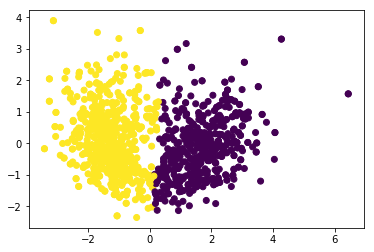

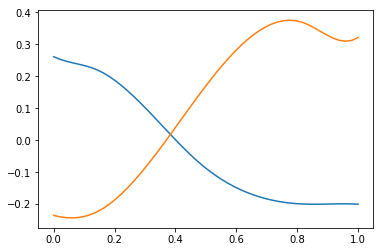

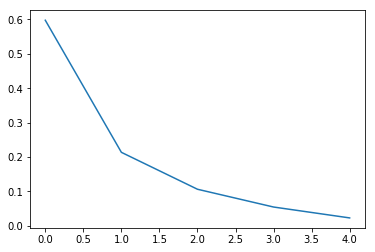

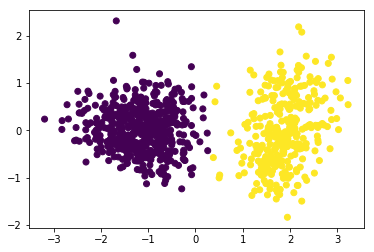

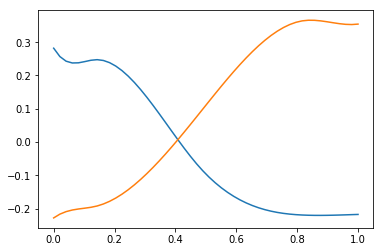

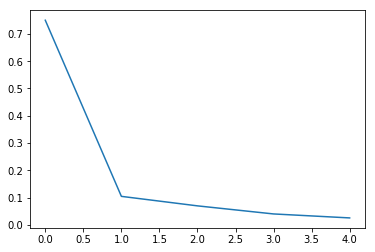

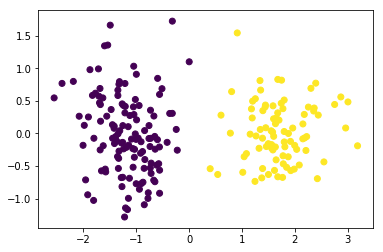

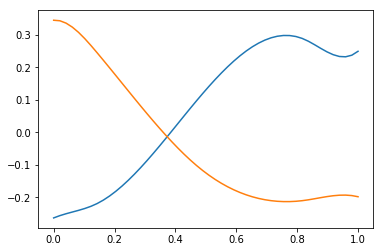

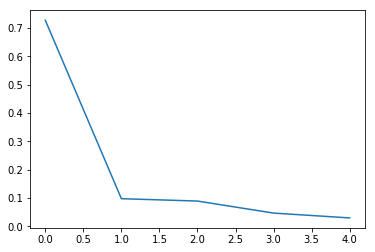

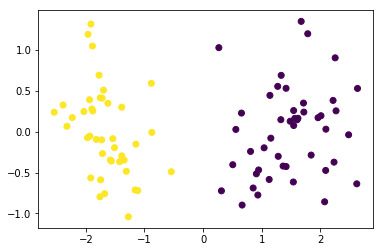

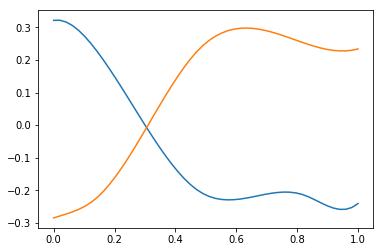

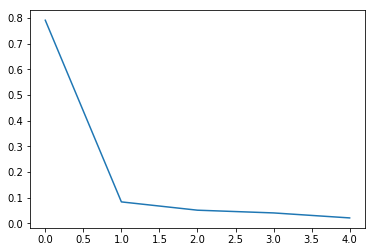

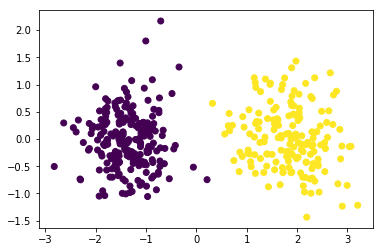

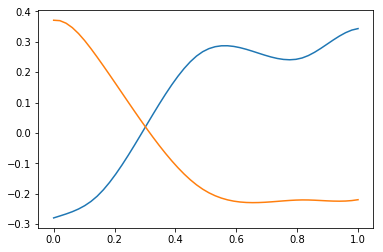

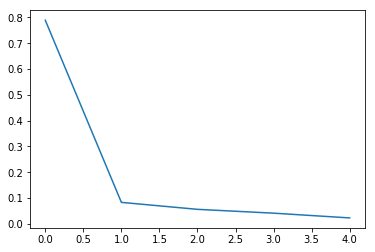

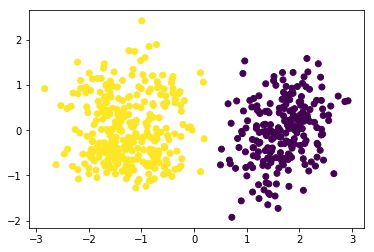

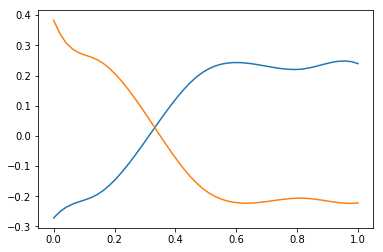

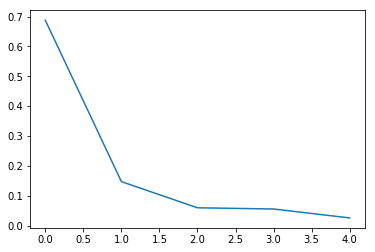

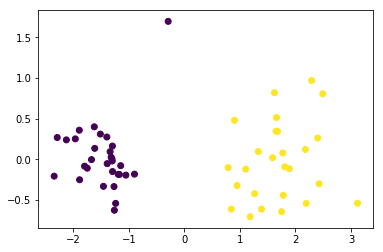

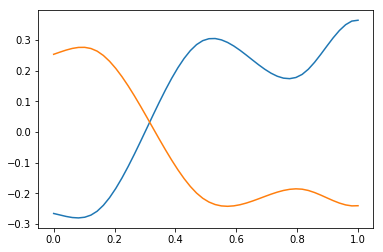

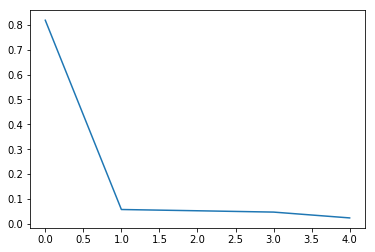

In [68]:
xx = np.linspace(0,1)
H = np.zeros([0,])
P = np.zeros([0,])
Y = np.zeros([0,xx.shape[0]])

for mouse in mice:
    df_mouse = df[df['MouseName'].str.match(mouse)]
    df_mouse = df_mouse[df_mouse['Track'].str.match('TwoTower_Timeout')]
    
    Hm = np.zeros([0,])
    Pm = np.zeros([0,])
    Ym = np.zeros([0,xx.shape[0]])
    
    for i in range(df_mouse.shape[0]):
        sess = df_mouse.iloc[i]
        path = os.path.join("G:\\My Drive\\EngramCoding\\KW\\C\\all","%s_%s_%d" % (mouse,sess.DateFolder,sess.SessionNumber))
        print(sess['data file'])
        VRDat = pp.behavior_dataframe(sess['data file'])
        trial_info, tstart_inds, teleport_inds = u.by_trial_info(VRDat)
        nm = np.unique(trial_info['morphs']).shape[0]
        if nm>2:
            try:
                H = np.append(H,np.load(os.path.join(path,"H.npy")))
                P = np.append(P,np.load(os.path.join(path,"P.npy")))
                Y = np.append(Y,np.load(os.path.join(path,"Yspl.npy")),axis=0)
                
                Hm = np.append(Hm,np.load(os.path.join(path,"H.npy")))
                Pm = np.append(Pm,np.load(os.path.join(path,"P.npy")))
                Ym = np.append(Ym,np.load(os.path.join(path,"Yspl.npy")),axis=0)
            except:
                print(mouse,nm)
                pass
    
    if Pm.shape[0]>0:
        sigInds = FDR(Pm,q=.005)
        Yms= Ym[sigInds,:]
        pca = sk.decomposition.PCA()
        Ymsr = pca.fit_transform(Yms[:,:])
        km = sk.cluster.KMeans(n_clusters = 2)
        labels = km.fit_predict(Yms)

        f,ax = plt.subplots()
        ax.scatter(Ymsr[:,0],Ymsr[:,1],c=1-labels,cmap='viridis')
        f.savefig(os.path.join("G:\\My Drive\\EngramCoding","%s_pc_scatter.png" % mouse),format='png')
        
        
        f,ax = plt.subplots()
        ax.plot(xx,km.cluster_centers_[0,:])
        ax.plot(xx,km.cluster_centers_[1,:])
        f.savefig(os.path.join("G:\\My Drive\\EngramCoding","%s_clust_centers.png" % mouse),format='png')


#         f,ax = plt.subplots()
#         ax.plot(xx,pca.components_[0,:] +pca.mean_)
#         ax.plot(xx,pca.components_[1,:]+pca.mean_)


        f,ax = plt.subplots()
        ax.plot(pca.explained_variance_ratio_[:5])
        f.savefig(os.path.join("G:\\My Drive\\EngramCoding","%s_pc_varex.png" % mouse),format='png')

In [50]:


sigInds = FDR(P)
Hs=H[sigInds]
Ys = Y[sigInds,:]
print(sigInds.shape)

(2269,)


(2269, 2)


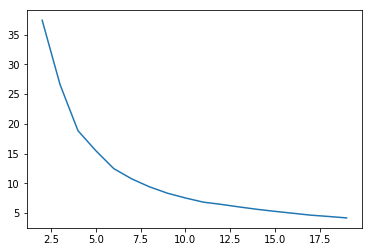

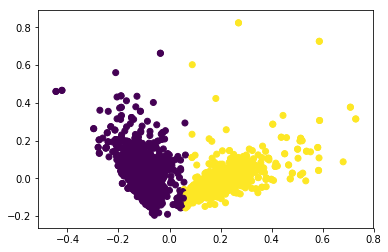

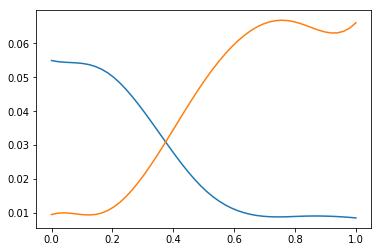

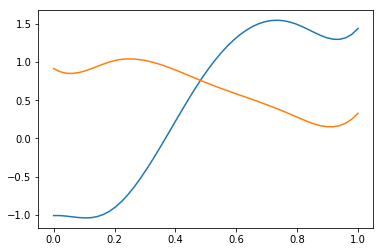

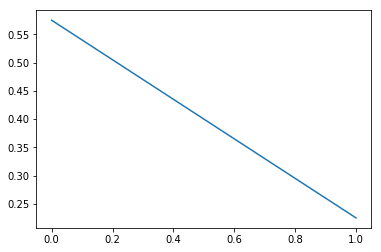

In [52]:
# from sklearn import decomposition

pca = sk.decomposition.PCA(n_components=2)
Y_pca = pca.fit_transform(Ys[:,:])
print(Y_pca.shape)
dist = np.zeros([18,])
for k in range(2,20):
    km = sk.cluster.KMeans(n_clusters = k)
    labels = km.fit_predict(Y_pca)
    dist[k-2]=km.inertia_.sum()
    
f,ax = plt.subplots()
ax.plot(np.arange(2,20),dist)
k = 2
km = sk.cluster.KMeans(n_clusters = k)
labels = km.fit_predict(Ys[:thr+1,:])

f,ax = plt.subplots()
ax.scatter(Y_pca[:,0],Y_pca[:,1],c=labels)
#f,ax = plt.subplots()
#ax.scatter(Y_pca[:,2],Y_pca[:,3],c=labels)
f,ax = plt.subplots()
mu0 = km.cluster_centers_[0,:]
mu1 = km.cluster_centers_[1,:]

# ax.plot(xx,np.dot(pca.components_.T,mu0[np.newaxis].T))
# ax.plot(xx,np.dot(pca.components_.T,mu1[np.newaxis].T))
# ax.plot(xx,np.dot(pca.components_.T,km.cluster_centers_[2,:].T))
# ax.plot(xx,np.dot(pca.components_.T,km.cluster_centers_[3,:].T))
# ax.plot(xx,np.dot(pca.components_.T,km.cluster_centers_[4,:].T))
ax.plot(xx,mu0)
ax.plot(xx,mu1)
# ax.plot(xx,km.cluster_centers_[2,:])
# ax.plot(xx,km.cluster_centers_[3,:])
# ax.plot(xx,km.cluster_centers_[4,:])
#ax.plot(xx,km.cluster_centers_[1,:])
f,ax = plt.subplots()
ax.plot(xx,pca.singular_values_[0]*pca.components_[0,:] +pca.mean_)
ax.plot(xx,pca.singular_values_[1]*pca.components_[1,:]+pca.mean_)
# ax.plot(xx,pca.singular_values_[2]*pca.components_[2,:]+pca.mean_)
#ax.set_xlabel('morph value')
#ax.set_ylabel('activity rate')

f,ax = plt.subplots()
ax.plot(pca.explained_variance_ratio_[:5])
